In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from prophet import Prophet
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

d:\Jean-Baptiste\Documents\Columbia\Courses\IEOR4571\Code\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Using device:  cuda


In [2]:
def open_data(print_head=False, print_shape=False, keep_date=False):
    df = pd.read_csv('Data\\QQQ_full.csv', header=0, parse_dates=True)
    del df['Unnamed: 0']
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True)
    df.set_index('Date', inplace=True)
    df['Volume'] = df['Volume'].str.replace(',', '')
    df['Volume'] = df['Volume'].astype(float)
    df = df.dropna()
    if not keep_date:
        df = df.reset_index(drop=True)
    if print_shape:
        print(df.shape)
    if print_head:
        print(df.head())
    return df

def plot_data(df, columns = ['Close']):
    plt.figure(figsize=(16, 8))
    for i, col in enumerate(columns):
        plt.subplot(len(columns), 1, i+1)
        plt.plot(df[col], label=col)
        plt.title(col, y=0.5, loc='right')
    plt.show()

(1195, 17)
              Open    High     Low   Close      Volume  1-month  3-month  \
Date                                                                       
2019-01-02  150.99  155.75  150.88  154.88  58576672.0     2.40     2.42   
2019-01-03  152.60  153.26  149.49  149.82  74820234.0     2.42     2.41   
2019-01-04  152.18  157.00  151.74  156.23  74709320.0     2.40     2.42   
2019-01-07  156.54  158.86  156.11  158.09  52059328.0     2.42     2.45   
2019-01-08  159.56  160.11  157.20  159.52  49388688.0     2.40     2.46   

            6-month  1-year  2-year  3-year  5-year  7-year  10-year  20-year  \
Date                                                                            
2019-01-02     2.51    2.60    2.50    2.47    2.49    2.56     2.66     2.83   
2019-01-03     2.47    2.50    2.39    2.35    2.37    2.44     2.56     2.75   
2019-01-04     2.51    2.57    2.50    2.47    2.49    2.56     2.67     2.83   
2019-01-07     2.54    2.58    2.53    2.51    2.53

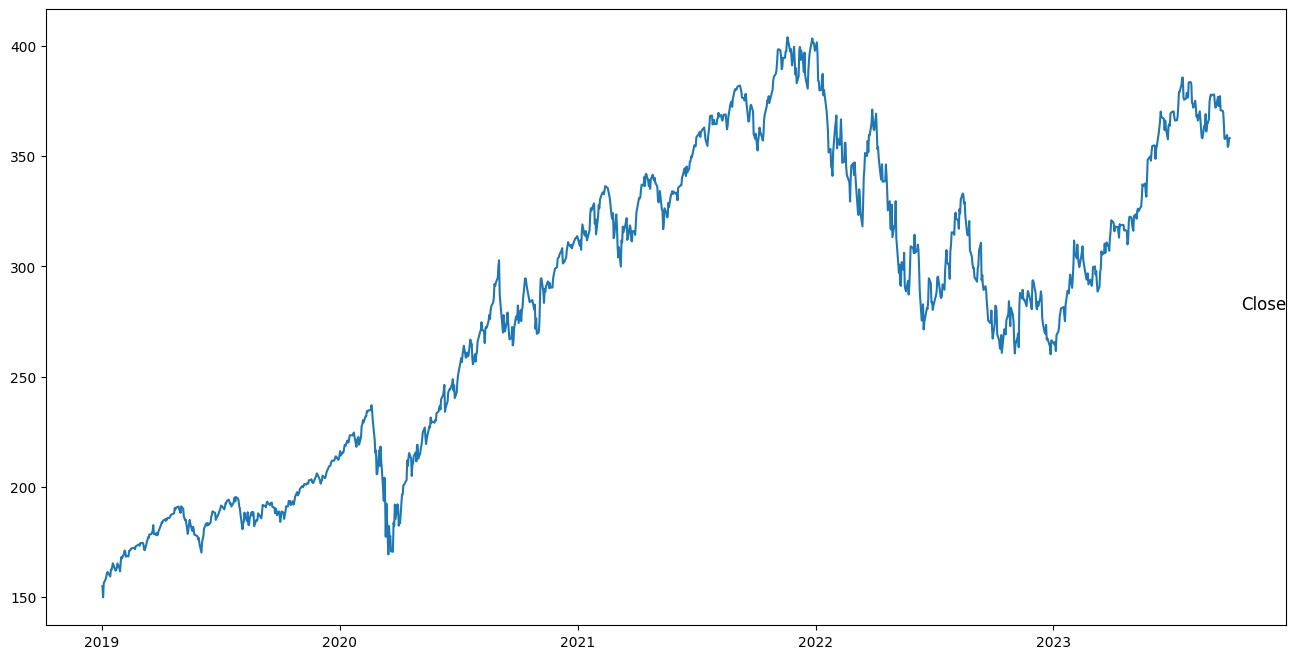

In [74]:
df = open_data(print_head=True, print_shape=True, keep_date=True)
df.index = pd.to_datetime(df.index)
plot_data(df)

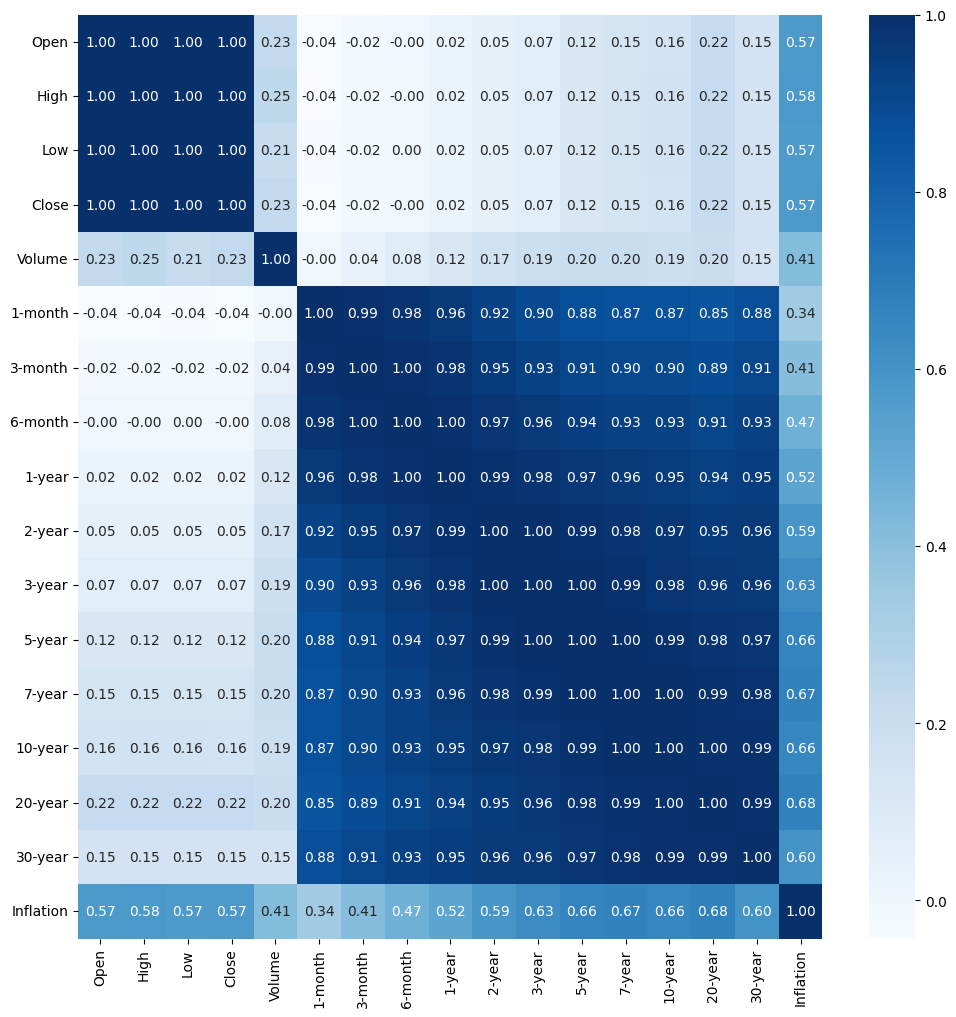

In [86]:
# Plot the correlation matrix
corr = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.show()

## Open and use the VIX data

                  VIX
Date                 
2018-12-18  24.680000
2018-12-19  25.150000
2018-12-20  26.090000
2018-12-21  28.240000
2018-12-24  29.290001


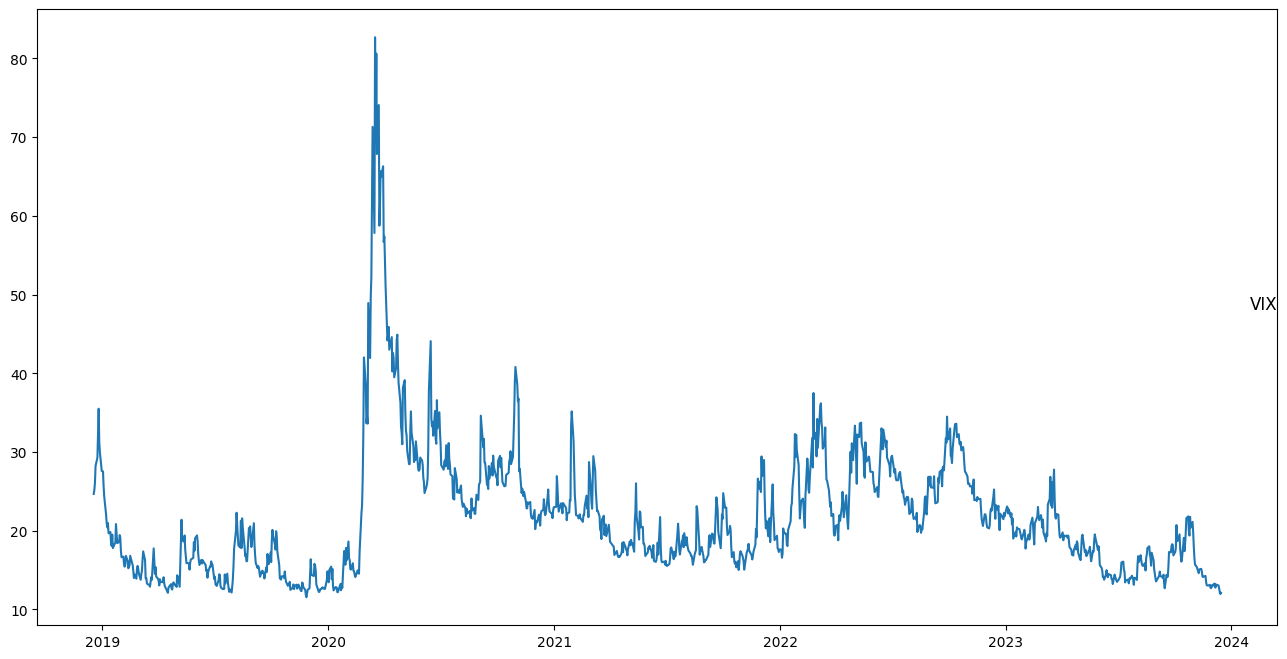

In [75]:
vix = pd.read_csv('Data\\VIX.csv', header=0, parse_dates=True)
vix.set_index('Date', inplace=True)
vix = vix.dropna()
vix = vix[['Open']]
vix.index = pd.to_datetime(vix.index)
vix.columns = ['VIX']
print(vix.head())
plot_data(vix, columns=['VIX'])

In [32]:
df = df[['Open', 'Close', '1-month', '3-month', '6-month', '1-year', '2-year', '3-year', '5-year', '7-year', '10-year', '20-year', '30-year', 'Inflation']]

In [87]:
df = df[['Open', 'Close', '3-year']]

In [88]:
# Join VIX data accoriding to date index
data = pd.merge(df, vix, left_index=True, right_index=True)
print(data.head())

              Open   Close  3-year        VIX
Date                                         
2019-01-02  150.99  154.88    2.47  27.540001
2019-01-03  152.60  149.82    2.35  25.680000
2019-01-04  152.18  156.23    2.47  24.360001
2019-01-07  156.54  158.09    2.51  22.059999
2019-01-08  159.56  159.52    2.57  20.959999


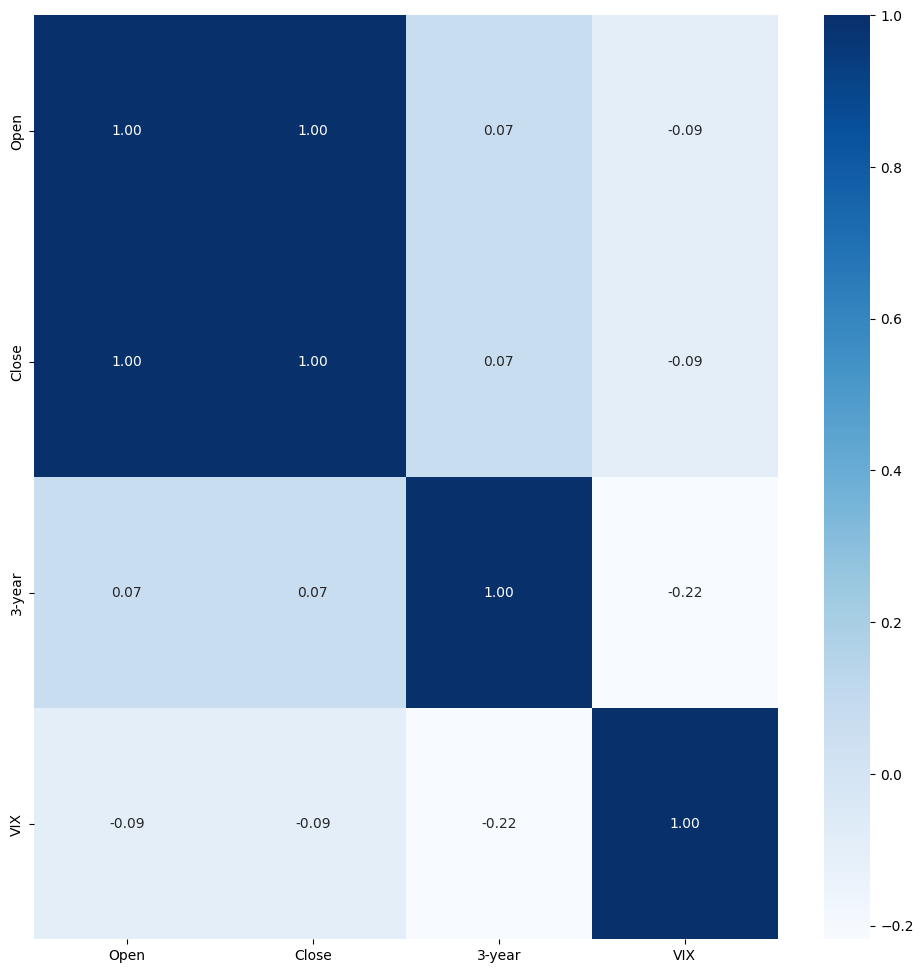

In [89]:
# Plot the correlation matrix
corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.show()

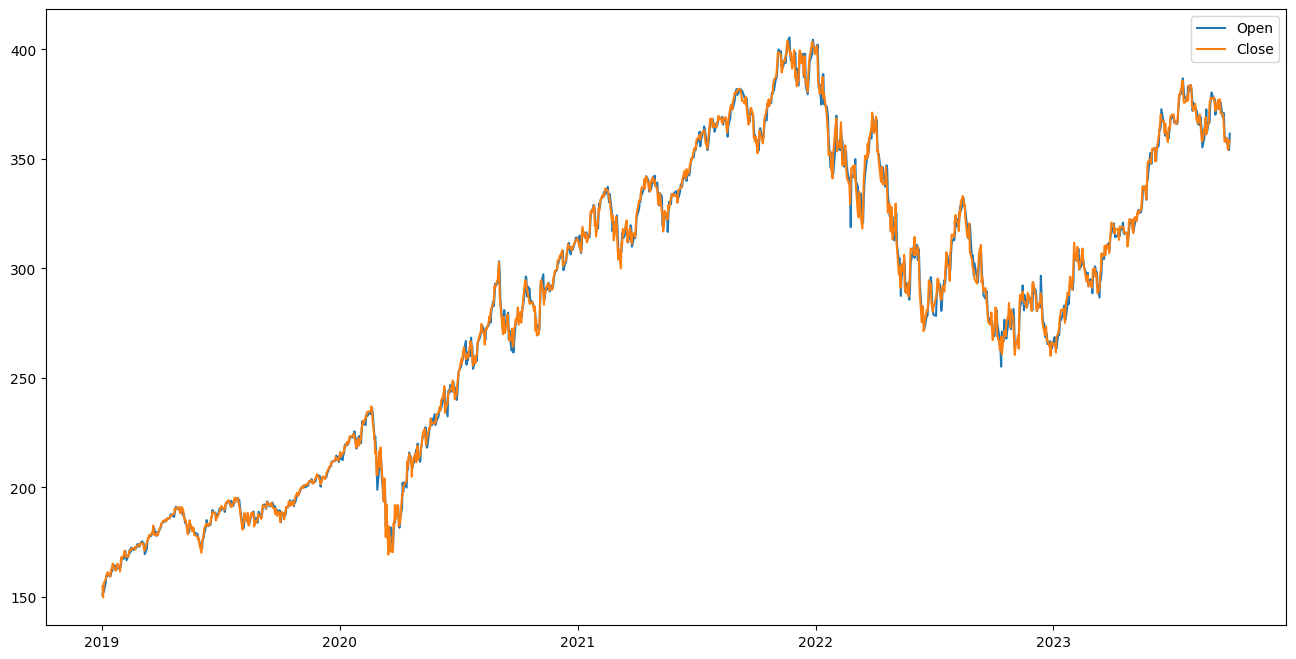

In [90]:
# Plot 'Close' against 'Open'
plt.figure(figsize=(16, 8))
plt.plot(data['Open'], label='Open')
plt.plot(data['Close'], label='Close')
plt.legend()
plt.show()

## Data Preparation

In [91]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

y = data[['Close']]
X = data.drop(['Close'], axis=1)

X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [92]:
class StockDataset(Dataset):
    def __init__(self, X, y, device=device, window=60):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)
        self.y = self.y.view(-1, 1)
        self.len = len(X) - window
        self.window = window
    
    def __getitem__(self, index):
        start = index
        end = index + self.window
        return self.X[start:end], self.y[end-1]
    
    def __len__(self):
        return self.len
    
train_set = StockDataset(X_train, y_train)
test_set = StockDataset(X_test, y_test)

## Model Building

In [104]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add 2 LSTM layers:
        self.lstm1 = nn.LSTM(input_size,hidden_size)
        self.lstm2 = nn.LSTM(hidden_size,hidden_size)
        
        # add 3 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out1, self.hidden = self.lstm1(
            seq.view(len(seq),1,-1), self.hidden)
        lstm_out2, self.hidden = self.lstm2(
            lstm_out1.view(len(seq),1,-1), self.hidden)
        pred = self.linear3(self.linear2(self.linear(lstm_out2.view(len(seq),-1))))
        return pred[-1]
    

class LSTMnetwork_2(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # add 2 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear2(self.linear(lstm_out.view(len(seq),-1)))
        return pred[-1]

## Model training

In [105]:
input_size = len(X_train[0])
model = LSTMnetwork_2(input_size=input_size).to(device)
criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

model

LSTMnetwork_2(
  (lstm): LSTM(3, 100)
  (linear): Linear(in_features=100, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=1, bias=True)
)

Epoch 0 Loss: 0.023109912872314453
Test loss: 0.3438819348812103
Epoch 1 Loss: 0.016897857189178467
Test loss: 0.3120553493499756
Epoch 2 Loss: 0.01516944169998169
Test loss: 0.2806931734085083
Epoch 3 Loss: 0.0009916126728057861
Test loss: 0.2218230962753296
Epoch 4 Loss: 0.018377184867858887
Test loss: 0.18216001987457275
Epoch 5 Loss: 0.01251634955406189
Test loss: 0.10007274150848389
Epoch 6 Loss: 0.005449056625366211
Test loss: 0.01467907428741455
Epoch 7 Loss: 0.010555386543273926
Test loss: 0.034990549087524414
Epoch 8 Loss: 0.03730660676956177
Test loss: 0.06184917688369751
Epoch 9 Loss: 0.0545274019241333
Test loss: 0.0785418152809143
Epoch 10 Loss: 0.015613734722137451
Test loss: 0.06738358736038208
Epoch 11 Loss: 0.02760910987854004
Test loss: 0.017411112785339355
Epoch 12 Loss: 0.02086123824119568
Test loss: 0.004120349884033203
Epoch 13 Loss: 0.02905622124671936
Test loss: 0.017042100429534912
Epoch 14 Loss: 0.004479706287384033
Test loss: 0.012455642223358154
Epoch 15 Los

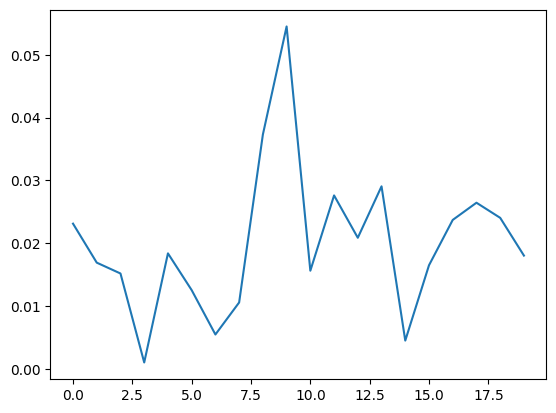

In [106]:
epochs = 20

losses = []

best_model = None
best_loss = 1000000

for i in range(epochs):
    for seq, y_true in train_set:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        y_pred = model(seq)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch {i} Loss: {loss.item()}')

    for seq, y_true in test_set:
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        with torch.no_grad():
            y_test_pred = model(seq)
            test_loss = criterion(y_test_pred, y_true)
    print(f'Test loss: {test_loss.item()}')
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model

plt.plot(range(epochs), losses)
plt.show()

## Model evaluation

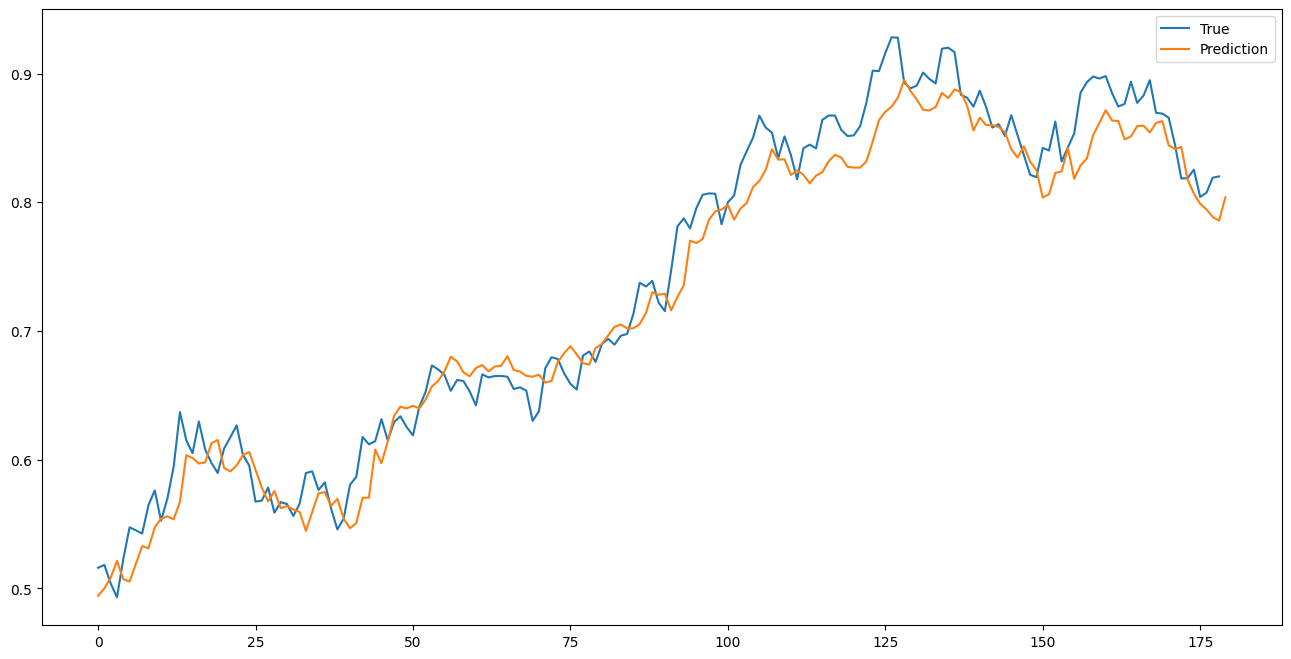

In [107]:
# predict the test set
test_preds = []
for seq, _ in test_set:
    best_model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                    torch.zeros(1, 1, model.hidden_size).to(device))
    with torch.no_grad():
        test_pred = model(seq)
        test_preds.append(test_pred.item())

y_test_array = y_test

# inverse the scaling
#test_preds = y_scaler.inverse_transform(np.array(test_preds).reshape(-1, 1))
#y_test = y_scaler.inverse_transform(y_test)
#test_preds = 60*[0] + list(test_preds.reshape(-1))
# plot the results
plt.figure(figsize=(16, 8))
plt.plot(list(y_test)[60:], label='True')
plt.plot(test_preds, label='Prediction')
plt.legend()
plt.show()

In [108]:
# Save the whole model
torch.save(model, 'small_model_2.pt')

## Regular NN

In [ ]:
# Build a regular fully connected neural network with relu activation

class FCnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.relu = nn.ReLU()
        
        # add 3 fully-connected layers:
        self.linear = nn.Linear(input_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,output_size)
        
    def forward(self,seq):
        pred = self.linear3(self.relu(self.linear2(self.relu(self.linear(seq)))))
        return pred[-1]

In [ ]:
# Create a dataset that contains the data from the last 10 days and return it as a big tensor

class StockDataset_2(Dataset):
    def __init__(self, X, y, device=device, window=60):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)
        self.y = self.y.view(-1, 1)
        self.len = len(X) - window
        self.window = window
    
    def __getitem__(self, index):
        start = index
        end = index + self.window
        # return it as a big tensor
        return self.X[start:end].view(-1), self.y[end-1]
    
    def __len__(self):
        return self.len

# Clustering

We are going to create a dataset that contains all the information about the 10 previous days, with all the data

In [55]:
# Create  a dataset containing for each sample the 10 previous days of data
X_cluster = []
y_cluster = []
for i in range(10, len(X_train)):
    X_cluster.append(X_train[i-10:i])
    y_cluster.append(y_train[i])

X_cluster = np.array(X_cluster)
y_cluster = np.array(y_cluster)
print(X_cluster.shape)
print(y_cluster.shape)

# Create a new vector "class" that contains 1 if the close is higher than the open and 0 otherwise
y_class = []
for i in range(len(y_cluster)):
    if y_cluster[i] > X_cluster[i][-1][1]:
        y_class.append(1)
    else:
        y_class.append(0)
y_class = np.array(y_class)
print(y_class.shape)

X_cluster_test = []
y_cluster_test = []
for i in range(10, len(X_test)):
    X_cluster_test.append(X_test[i-10:i])
    y_cluster_test.append(y_test[i])

X_cluster_test = np.array(X_cluster_test)
y_cluster_test = np.array(y_cluster_test)
print(X_cluster_test.shape)
print(y_cluster_test.shape)

y_class_test = []
for i in range(len(y_cluster_test)):
    if y_cluster_test[i] > X_cluster_test[i][-1][1]:
        y_class_test.append(1)
    else:
        y_class_test.append(0)

(826, 10, 14)
(826, 1)
(826,)
(349, 10, 14)
(349, 1)


In [56]:
# Train a XGBoost model for clustering
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_cluster.reshape(X_cluster.shape[0], -1), y_class)

# Print the accuracy of the model
print(model.score(X_cluster.reshape(X_cluster.shape[0], -1), y_class))

# Predict the class of the test set
y_class_pred = model.predict(X_cluster_test.reshape(X_cluster_test.shape[0], -1))

# Print the accuracy of the model
print(model.score(X_cluster_test.reshape(X_cluster_test.shape[0], -1), y_class_test))



1.0
0.33810888252148996
